<a href="https://colab.research.google.com/github/ralfcam/trade_notebooks/blob/master/btc_trade_alysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Imports

In [0]:
import pandas as pd  
import numpy as np
from pandas_datareader import data, wb
import datetime
import scipy.optimize as sco
from scipy import stats

import plotly.graph_objects as go
from plotly.subplots import make_subplots

%matplotlib inline
%load_ext google.colab.data_table

tickers = ['SPY', 'BTC-USD']  # 'AAPL', 'MSFT', 'NFLX', 'AMZN', 'GOOG',
stock_in = 'BTC-USD'  # e.g.tickers[-1]

start = datetime.datetime(2008, 1, 1)
end = datetime.datetime(2023, 3, 23)

### Functions Decl.


In [0]:
def plot_rows(index, *args, v_names=("Price","Trend", "Cycle") ):
  fig = make_subplots(
    rows=len(args), cols=1,
    # specs=[[{}, {}],
    #        [{"colspan": 3}, None]],
    subplot_titles=v_names
    )
  for i, arg in enumerate(args):
    fig.append_trace(go.Scatter(
        x=index,
        y=arg
    ), row=i+1, col=1)
  fig.update_layout(height=600,
                    width=1200, 
                    showlegend=False,
                    # title_text=" HP filter "
                    )
  fig.show()


def candle_stock_in(barset_df):
  fig = go.Figure(data=[go.Candlestick(
    x=barset_df.index,
    open=barset_df['Open'],
    high=barset_df['High'],
    low=barset_df['Low'],
    close=barset_df['Close'])
  ])
  fig.update_layout(
      title=f"{stock_in}",
      xaxis_title="Price USD",
      yaxis_title="Time",
      font=dict(
          family="Courier New, monospace",
          size=18,
          color="#7f7f7f"
      )
  )
  fig.show()


### Data Reader


In [0]:
dic_stocks_dfs = {ticker: data.DataReader(ticker, 'yahoo', start, end) for ticker in tickers}

In [0]:
barset_df = dic_stocks_dfs[stock_in]
series_resampled_imputed = barset_df['Adj Close'].resample('d').mean().ffill()
# dic_stocks_dfs['AAPL'] 

In [0]:
mask = (series_resampled_imputed.index > '2015') & (series_resampled_imputed.index < '2020')
series_resampled_masked_imputed = series_resampled_imputed.loc[mask]

In [42]:
candle_stock_in(barset_df)

In [86]:
series_resampled_masked_imputed

Date
2015-01-02     315.032013
2015-01-03     281.082001
2015-01-04     264.195007
2015-01-05     274.473999
2015-01-06     286.188995
                 ...     
2019-12-27    7290.088379
2019-12-28    7317.990234
2019-12-29    7422.652832
2019-12-30    7292.995117
2019-12-31    7193.599121
Freq: D, Name: Adj Close, Length: 1825, dtype: float64

### Google Trends

In [0]:
!pip install pytrends

In [0]:
from pytrends.request import TrendReq
pytrend = TrendReq()

In [0]:
kw_list = ['BTC']

btc_searches_df = pytrend.get_historical_interest(
    kw_list,
    year_start=2010,
    month_start=1,
    day_start=1,
    hour_start=0,
    year_end=2020,
    month_end=2,
    day_end=1,
    hour_end=0,
    cat=0,
    geo='',
    gprop='',
    sleep=1
    )

In [0]:
btc_resampled_searches_df = btc_searches_df.resample('d').mean().ffill()

In [0]:
mask = (btc_resampled_searches_df.index > '2015') & (btc_resampled_searches_df.index < '2020')
btc_resampled_masked_searches_df = btc_resampled_searches_df.loc[mask]

In [0]:
btc_resampled_masked_searches_df.to_pickle("./btc_resampled_masked_searches_df.pkl")

In [0]:
plot_rows(
    btc_resampled_masked_searches_df.index,
    btc_resampled_masked_searches_df['BTC'],
    series_resampled_masked_imputed,
    v_names=("Google Searches")
    )

corr = np.correlate(btc_resampled_masked_searches_df['BTC'], series_resampled_masked_imputed)
print(f'Correlation is: {corr}')

## Statistical Analysis


[![statsmodels](https://www.statsmodels.org/stable/_images/statsmodels-logo-v2-horizontal.svg)](https://www.statsmodels.org/stable/index.html)

In [0]:
!pip install cython
!pip install git+https://github.com/statsmodels/statsmodels.git

### Hodrick-Prescott filter Decomposition


In [0]:
from statsmodels.tsa.filters.hp_filter import hpfilter

cycle, trend = hpfilter(series_resampled_masked_imputed)

In [80]:
plot_rows(
    barset_df.index,
    barset_df['Close'],
    trend,
    cycle
    )

corr = np.correlate(btc_resampled_masked_searches_df['BTC'], cycle)
print(f'Correlation is: {corr}')

Correlation is: [569750.37206038]


In [82]:
569750.37206038 > 4.51151485e+08

False

### STL Decomposition

In [0]:
from statsmodels.tsa.seasonal import STL
result = STL(series_resampled_imputed).fit()

In [0]:
plot_rows(
    barset_df.index,
    result.observed,
    result.seasonal,
    result.trend,
    result.resid,
    v_names=("Price", "Seasonal","Trend", "Residual")
    )

corr = np.correlate(btc_resampled_masked_searches_df['BTC'], result.trend)
print(f'Correlation is: {corr}')

### Season & Residual spectrogram

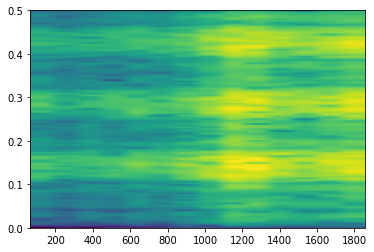

In [0]:
from scipy import ndimage
from matplotlib import pyplot as plt

Pxx, freqs, bins, im = plt.specgram(result.seasonal, Fs=1e0)

In [0]:
# k = np.array([[0,0,0,0,0],[1,1,1,1,1],[3,3,3,3,3],[1,1,1,1,1],[0,0,0,0,0]])
# plt.contourf(ndimage.convolve(Pxx, k))


## Inference

In [0]:
import numpy as np
from sklearn.metrics import mean_squared_error

len_s = len(series_resampled_imputed)
int_len_s = int( len_s * 0.7)

predictions = series_resampled_imputed.shift(1).dropna()
test_score = np.sqrt(mean_squared_error(series_resampled_imputed[int_len_s + 1:], predictions.iloc[int_len_s:]))
print('“baseline” model score RMSE: %.5f' % test_score)

“baseline” model score RMSE: 304.70909


In [0]:
from pandas import Series, concat
from statsmodels.tsa.ar_model import AutoReg

component_dict = {'seasonal': result.seasonal, 'trend': result.trend, 'residual': result.resid}

prediction_results = []

for component in ['seasonal', 'trend', 'residual']:
    historic = component_dict[component].iloc[:int_len_s].to_list()
    test = component_dict[component].iloc[int_len_s:]

    predictions = []
    for i in range(len(test)):

        model = AutoReg(historic, 4)
        model_fit = model.fit()
        pred = model_fit.predict(start=len(historic), end=len(historic)+5, dynamic=False)
        predictions.append(pred[0])
        historic.append(test[i])

    predictions = Series(predictions, index=test.index, name=component)
    prediction_results.append(predictions)
    test_score = np.sqrt(mean_squared_error(test, predictions))
    print(f'Test for {component} MSE: {test_score}')

Test for seasonal MSE: 86.7014666112001
Test for trend MSE: 16.68495162621697
Test for residual MSE: 166.00200937520952


In [0]:
pred

array([-47.09537298,  17.89839378,  34.88814574,  11.96836934,
        -8.90461922, -11.1982965 ])

In [0]:

recomposed_preds = concat(prediction_results,axis=1).sum(axis=1)
len_pred = len(recomposed_preds)

predictions = series_resampled_imputed.shift(1).dropna()
test_score = np.sqrt(mean_squared_error(series_resampled_imputed[int_len_s:], recomposed_preds))
print(f'RMSE: {test_score}')
print(f"Pred. Lenght {len_pred}")

RMSE: 195.9828131678887
Pred. Lenght 605


In [0]:
len(prediction_results[0].values)

605

In [0]:
plot_rows(
    barset_df.index[-len_pred:],
    result.observed[-len_pred:],
    prediction_results[0].values,
    prediction_results[1].values,
    prediction_results[2].values,
    recomposed_preds,
    v_names=("Real Price", "Prediction Seasonal", "Prediction Trend", "Prediction Resid", "Prediction Composed")
    )


[![google-colab-and-alpaca](https://miro.medium.com/max/1042/1*XxI5SV1iXJx7b67IMSu1Tg.png)](https://medium.com/automation-generation/analyze-data-and-trade-stocks-with-only-a-browser-using-google-colab-and-alpaca-api-97d2bf034e2e)



In [0]:
print(f"https://app.alpaca.markets/paper/stocks/{stock_i}")

In [0]:
!pip3 install alpaca-trade-api

In [0]:
YOUR_API_SECRET_KEY = 'OvNcKYXjyQmPUj6ZH8rcOoWrdouHOOsLs0RW0/7p'
YOUR_API_KEY_ID = 'PKSP20Y2JEVI0IZ50XCJ'

import alpaca_trade_api as alpaca
api = alpaca.REST(
    YOUR_API_KEY_ID,
    YOUR_API_SECRET_KEY,
    api_version='v2',
    base_url='https://paper-api.alpaca.markets'
    )

In [0]:
acc_info = api.get_account()
type(acc_info)

alpaca_trade_api.entity.Account

In [0]:
# api.submit_order('AAPL', side='buy', qty=1, type='market', time_in_force='gtc')

In [0]:
# api.list_positions()

In [0]:
# api.list_orders()

In [0]:
# stock_i = 'SPY'
# barset_json = api.get_barset(stock_i, 'day', limit=1000)
# barset_df = barset_json[stock_i].df.resample('d').mean().ffill()